In [20]:
import os
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

In [2]:
# Setup working directory and relative filepaths
current_dir = os.curdir
data_dir = os.path.join(current_dir, "data")
output_dir = os.path.join(current_dir, "data_clean")

# Get data path
abc_data_dir = os.path.join(data_dir, "abc-news.csv")
bbc_data_dir = os.path.join(data_dir, "bbc-news.csv")
cbs_data_dir = os.path.join(data_dir, "cbs-news.csv")
cnn_data_dir = os.path.join(data_dir, "cnn-news.csv")

# Read csv data
abc_data_csv = pd.read_csv(abc_data_dir, encoding="utf-16")
bbc_data_csv = pd.read_csv(bbc_data_dir, encoding="utf-16")
cbs_data_csv = pd.read_csv(cbs_data_dir, encoding="utf-16")
cnn_data_csv = pd.read_csv(cnn_data_dir, encoding="utf-16")

In [3]:
abc_data_df = pd.DataFrame(abc_data_csv.copy())
bbc_data_df = pd.DataFrame(bbc_data_csv.copy())
cbs_data_df = pd.DataFrame(cbs_data_csv.copy())
cnn_data_df = pd.DataFrame(cnn_data_csv.copy())

In [4]:
# Remove columns from Dataframe
col_ls = ['id', 'page_id', 'message', 'description', 'caption', 'picture']
abc_data_df.drop(columns = col_ls, inplace = True)
bbc_data_df.drop(columns = col_ls, inplace = True)
cbs_data_df.drop(columns = col_ls, inplace = True)
cnn_data_df.drop(columns = col_ls, inplace = True)

In [5]:
class CleanData:
    def __init__(self, df): # initialize CleanData
        self.df = df

    def show_df(self): # Show dateframe object when passed to CleanData
        return self.df
    
    def news_outlet(self, outlet=''): # append news outlet name to self.df as a new column

        self.df['news_outlet'] = outlet
        return self.df
    
    def numeric_category(self): # Determine how many post_types and status_types and factorize types, use method only on combined dataframe

        self.post_types_unique = pd.unique(self.df['post_type'])
        self.post_types_factorize = pd.factorize(self.post_types_unique, sort=True)[0]
        self.status_types_unique = pd.unique(self.df['status_type'])
        self.status_types_unique = [i for i in self.status_types_unique if str(i) != 'nan']
        self.status_types_factorize = pd.factorize(self.status_types_unique, sort=True)[0]

        self.post_types_dict = dict(zip(self.post_types_unique, self.post_types_factorize)) # Create dictionary for post_types and status_types
        self.status_types_dict = dict(zip(self.status_types_unique, self.status_types_factorize))
        
        def post_cat(x):
            for type, category in self.post_types_dict.items():
                if x in type:
                    return category

        def status_cat(x):
            for type, category in self.status_types_dict.items():
                if x in type:
                    return category
            
        self.df['post_category'] = self.df['post_type'].apply(post_cat)
        self.df['status_category'] = self.df['status_type'].apply(status_cat)

        return self.df

    def calculate_reacts(self): # Calculate reacts for self.df

        self.react_col = ['likes_count', 'comments_count', 'shares_count', 'love_count', # store columns of interest 
            'wow_count', 'haha_count', 'sad_count', 'thankful_count', 'angry_count',]
        self.df['total_reacts'] = self.df[self.react_col].sum(axis=1) # sum self.react_col by row

        return self.df

    def clean_datetime(self): # Clean datetime of self.df

        def round_hour(t):
            t_start_hr = t.replace(minute=0, second=0, microsecond=0) # round to down to nearest hour
            t = t_start_hr
            return t

        self.df['posted_at'] = pd.to_datetime(self.df['posted_at']) # change dtype to datetime
        self.df['posted_at'] = self.df['posted_at'].apply(round_hour) # apply round_hour
        self.df['date_posted'] = [date.date() for date in self.df['posted_at']] # store date() from datetime object
        self.df['time_posted'] = [time.time() for time in self.df['posted_at']] # store time() from datetime object
        self.df.drop(columns=['posted_at'], inplace=True)

        return self.df
    
    def analyze_df(self):

        def analyze_sentiment(headline):
            analysis = TextBlob(str(headline))
            return analysis.sentiment # returns sentiment, subjectivity

        self.df[['name_sentiment', 'name_subjectivity']] = np.array([analyze_sentiment(str(headline)) for headline in self.df['name']]) # store sentiment, subjectivity in new columns

        return self.df

    def fill_na(self):
        self.df['status_type'] = self.df['status_type'].fillna(self.df.mode().iloc[0][2]) # self.df.mode().iloc[0] returns a list of the most frequent values for each column in self.df iloc[0][2] accesses status_type
        return self.df

In [6]:
 # ABC Data cleaning
abc_data_clean = CleanData(abc_data_df)
abc_data_clean.fill_na()
abc_data_clean.news_outlet(outlet='ABC')
abc_data_clean.calculate_reacts()
abc_data_clean.clean_datetime()
abc_data_clean.analyze_df()
abc_data_clean = abc_data_clean.show_df()

In [7]:
 # BBC Data cleaning
bbc_data_clean = CleanData(bbc_data_df)
bbc_data_clean.fill_na()
bbc_data_clean.news_outlet(outlet='BBC')
bbc_data_clean.calculate_reacts()
bbc_data_clean.clean_datetime()
bbc_data_clean.analyze_df()
bbc_data_clean = bbc_data_clean.show_df()

In [8]:
 # CBS Data cleaning
cbs_data_clean = CleanData(cbs_data_df)
cbs_data_clean.fill_na()
cbs_data_clean.news_outlet(outlet='CBS')
cbs_data_clean.calculate_reacts()
cbs_data_clean.clean_datetime()
cbs_data_clean.analyze_df()
cbs_data_clean = cbs_data_clean.show_df()

In [9]:
# CNN Data cleaning
cnn_data_clean = CleanData(cnn_data_df)
cnn_data_clean.fill_na()
cnn_data_clean.news_outlet(outlet='CNN')
cnn_data_clean.calculate_reacts()
cnn_data_clean.clean_datetime()
cnn_data_clean.analyze_df()
cnn_data_clean = cnn_data_clean.show_df()

In [10]:
 # Combine news outlet and store in new dataframe
news_data_combined_df = pd.concat([abc_data_clean, bbc_data_clean, cbs_data_clean, cnn_data_clean])

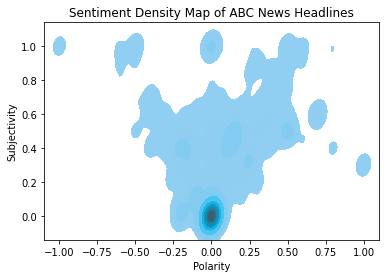

In [13]:
 # Show sentiment density using seaborn
chart = plt.figure('ABC')
sentiment_density = sns.kdeplot(data=abc_data_clean, y='name_subjectivity', x='name_sentiment', fill=True, color='#33C9FF')
sentiment_density.set(xlabel='Polarity', ylabel='Subjectivity', title='Sentiment Density Map of ABC News Headlines')
plt.show()

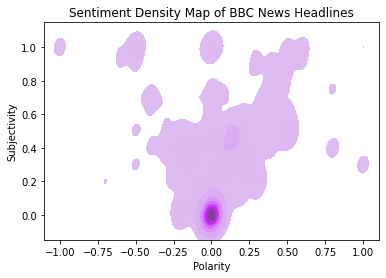

In [14]:
chart = plt.figure('BBC')
sentiment_density = sns.kdeplot(data=bbc_data_clean, y='name_subjectivity', x='name_sentiment', fill=True, color='#CF33FF')
sentiment_density.set(xlabel='Polarity', ylabel='Subjectivity', title='Sentiment Density Map of BBC News Headlines')
plt.show()

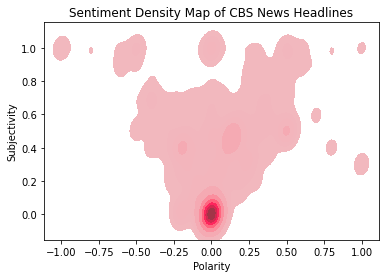

In [16]:
chart = plt.figure('CBS')
sentiment_density = sns.kdeplot(data=cbs_data_clean, y='name_subjectivity', x='name_sentiment', fill=True, color='#FF3363')
sentiment_density.set(xlabel='Polarity', ylabel='Subjectivity', title='Sentiment Density Map of CBS News Headlines')
plt.show()

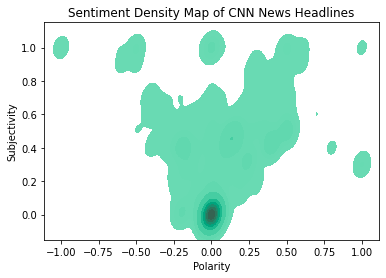

In [18]:
chart = plt.figure('CNN')
sentiment_density = sns.kdeplot(data=cnn_data_clean, y='name_subjectivity', x='name_sentiment', fill=True, color='#33FFC6')
sentiment_density.set(xlabel='Polarity', ylabel='Subjectivity', title='Sentiment Density Map of CNN News Headlines')
plt.show()

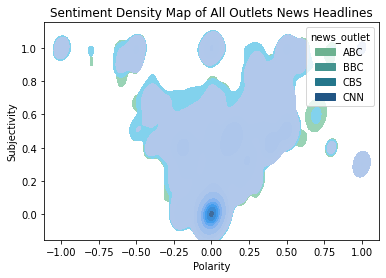

In [31]:
chart = plt.figure('Combined Outlets')
sentiment_density = sns.kdeplot(data=news_data_combined_df, y='name_subjectivity', x='name_sentiment', hue='news_outlet' , fill=True, palette='crest')
sentiment_density.set(xlabel='Polarity', ylabel='Subjectivity', title='Sentiment Density Map of All Outlets News Headlines')
plt.show()

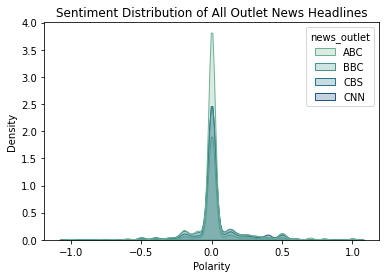

In [30]:
sentiment_distribution = sns.kdeplot(data=news_data_combined_df, x='name_sentiment', hue='news_outlet', fill=True, palette='crest')
sentiment_distribution.set(xlabel='Polarity', title='Sentiment Distribution of All Outlet News Headlines')
plt.show()